In [1]:
import sys
sys.path.append('../../../')
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence
from tifffile import imread
from tqdm import tqdm
import inspect
import glob
from sklearn.cluster import KMeans

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
patch_size = 64
centre_size = 4
n_channel = 32
hierarchy_level = 3

In [3]:
def load_model(dir):
    model = torch.load(dir+"Contrastive_MAE_best_vae.net")
    return model

In [4]:
def load_losses(dir):
    trainHist=np.load(dir+"train_loss.npy")
    reconHist=np.load(dir+"train_reco_loss.npy")
    klHist=np.load(dir+"train_kl_loss.npy")
    clHist=np.load(dir+"train_cl_loss.npy")
    valHist=np.load(dir+"val_loss.npy")
    return [trainHist, reconHist, klHist, clHist, valHist]

In [5]:
def plot_loss(losses):

    plt.figure(figsize=(18, 18))

    plt.subplot(2,2,1)
    plt.plot(losses['trainHist'],label='training')
    plt.plot(losses['valHist'],label='validation')
    plt.xlabel("epochs")
    plt.ylabel("overall loss")
    plt.legend()

    plt.subplot(2,2,2)
    plt.plot(losses['reconHist'],label='training')
    plt.xlabel("epochs")
    plt.ylabel("Inpainting loss")
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(losses['klHist'],label='training')
    plt.xlabel("epochs")
    plt.ylabel("KL loss")
    plt.legend()

    plt.subplot(2,2,4)
    plt.plot(losses['clHist'],label='training')
    plt.xlabel("epochs")
    plt.ylabel("CL loss")
    plt.legend()
    plt.show()

In [6]:
def get_normalized_tensor(img,model,device):
    test_images = torch.from_numpy(img.copy()).to(device)
    data_mean = model.data_mean
    data_std = model.data_std
    test_images = (test_images-data_mean)/data_std
    return test_images

In [7]:
def load_data(dir):
    return imread(dir)

In [8]:
model_dir = "/group/jug/Sheida/HVAE/Hyperparameter_search/legendary-violet-547-2nd-cl1e-3_kl1/model/"
data_dir = "/localscratch/test_imgs/*"

In [9]:
model = load_model(model_dir)
loss_keys = ['trainHist', 'reconHist', 'klHist', 'clHist', 'valHist']
loss_dict = dict()
losses = load_losses(model_dir)
for index, key in enumerate(loss_keys):
    loss_dict[key] = losses[index]

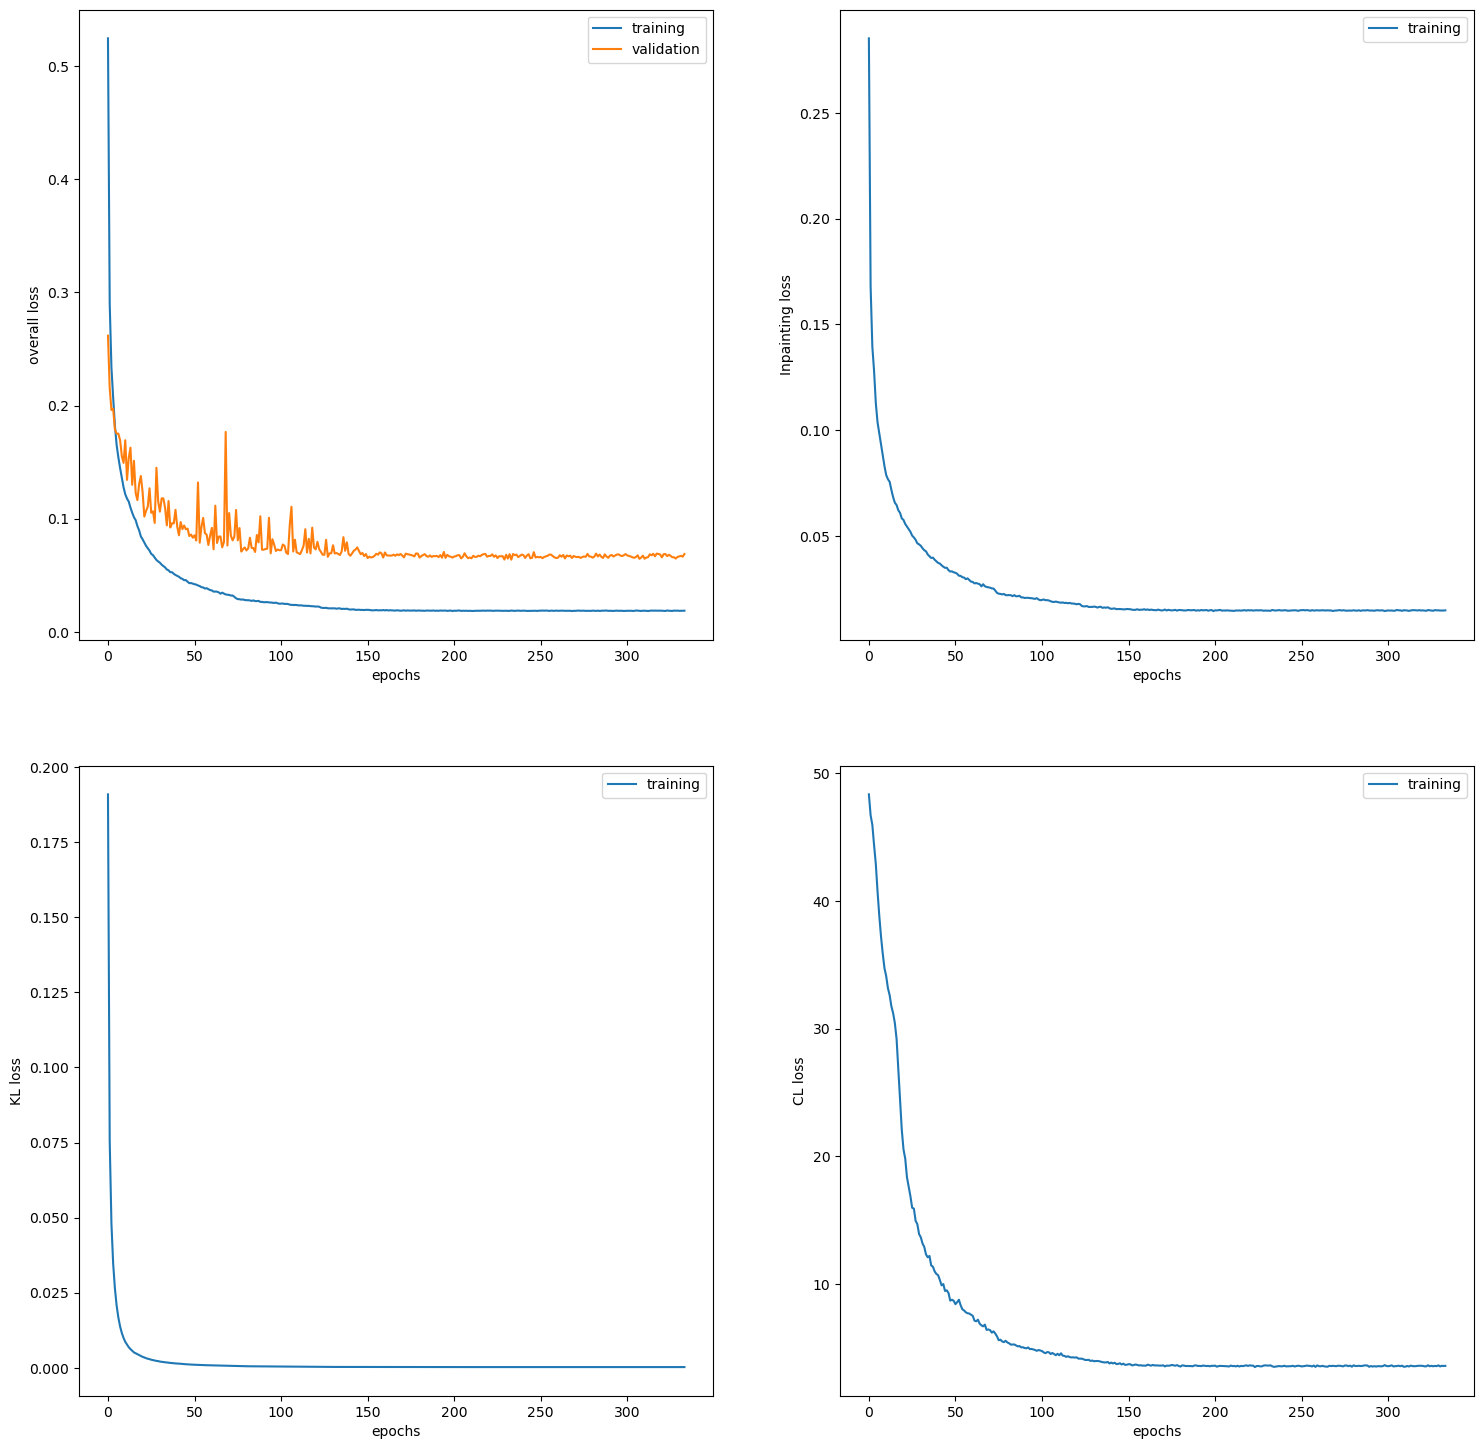

In [10]:
plot_loss(loss_dict)


In [11]:
imgs = load_data(sorted(glob.glob(data_dir)))

In [12]:
imgs[0].shape

(699, 760)

In [13]:
def mirror_image(image):
    """
    Mirror the borders of the image to handle edge cases.
    """
    pad_size = (patch_size - centre_size) // 2
    mirrored_image = np.pad(image, ((pad_size, pad_size)), mode='reflect')
    return mirrored_image

In [14]:
def pad_to_divisible_by(image, centre_size):
    """
    Pads the image so that its dimensions are divisible by 4.
    """
    h, w = image.shape[:2]
    
    # Calculate the padding needed for each dimension
    pad_h = (centre_size - h % centre_size) % centre_size
    pad_w = (centre_size - w % centre_size) % centre_size
    
    # Padding in (before, after) format
    padding = ((0, pad_h), (0, pad_w)) + ((0, 0),) * (image.ndim - 2)
    
    # Pad the image
    padded_image = np.pad(image, padding, mode='constant', constant_values=0)
    
    return padded_image

In [15]:
def extract_patch(image, x, y):
    """
    Extract a patch from the image centered at (x, y).
    """
    return image[x : x + patch_size, y : y + patch_size]

In [16]:
def extract_center(x):
    _, _, h, w = x.shape
    h_start = (h - centre_size) // 2
    w_start = (w - centre_size) // 2
    return x[:, :, h_start:h_start + centre_size, w_start:w_start + centre_size].squeeze(0)

In [17]:
def get_mus(model, z):
    n_features = n_channel * hierarchy_level
    model.mode_pred=True
    model.eval()
    with torch.no_grad():
        model.to(device)
        z = z.to(device=device, dtype=torch.float)
        z = z.reshape(1,1,patch_size,patch_size)
        with torch.no_grad():
                sample = model(z, z, z,model_layers=[0,1,2])
                mu = sample['mu']
                centers = [extract_center(arr).cpu().numpy() for arr in mu]
                concatenated_centers = np.concatenate(centers, axis=0).T
    return concatenated_centers

In [18]:
def predict_feature_maps(model, image):
    """
    Predict the feature maps for an image using the model.
    """
    height, width= image.shape
    feature_maps = np.zeros((height-(patch_size-centre_size), width-(patch_size-centre_size), hierarchy_level * n_channel))    
    for x in range(0, height - patch_size, centre_size):
        for y in range(0, width - patch_size, centre_size):
            patch = extract_patch(image, x, y)
            mus = get_mus(model, patch)
            feature_maps[x:x+centre_size,y:y+centre_size,:] = mus
    return feature_maps

In [19]:
def clustering(mu):
    slice_features_mu = mu.astype(float)
    feature_flatten_mu = slice_features_mu.reshape(-1, 96)
    K_CENTRE = 3
    kmeans_mu = KMeans(
        n_clusters=K_CENTRE, init='k-means++', n_init=10,
        max_iter=1000, random_state=777
    )
    kmeans_mu.fit(feature_flatten_mu)
    labels_mu = kmeans_mu.predict(feature_flatten_mu)
    return labels_mu

In [20]:
x = get_normalized_tensor(pad_to_divisible_by(mirror_image(imgs[0]), centre_size),model,device)

In [21]:
x.shape

torch.Size([760, 820])

In [22]:
feature_maps = predict_feature_maps(model, x)

In [23]:
feature_maps.shape

(700, 760, 96)

In [24]:
import pickle
with open('array.pkl', 'wb') as f:
    pickle.dump(feature_maps, f)

In [25]:
with open('array.pkl', 'rb') as f:
    feature_maps = pickle.load(f)

In [26]:
labels = clustering(feature_maps)

In [27]:
labels.shape

(532000,)

In [28]:
labels.reshape(feature_maps.shape[0], feature_maps.shape[1]).shape

(700, 760)

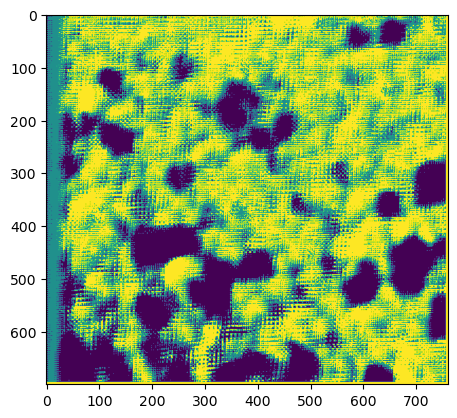

In [29]:
plt.imshow(labels.reshape(feature_maps.shape[0], feature_maps.shape[1]))

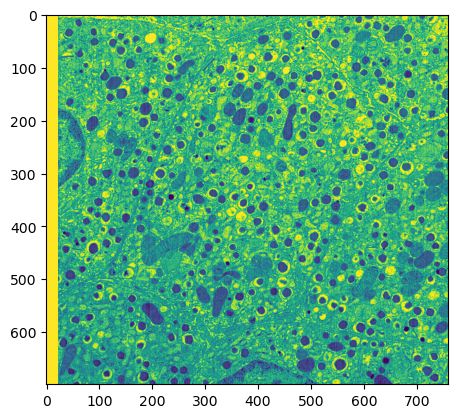

In [30]:
plt.imshow(imgs[0])

In [31]:
np.unique(labels)

array([0, 1, 2], dtype=int32)

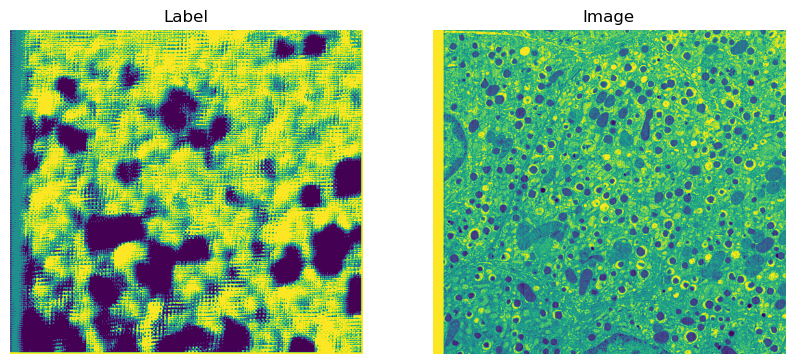

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(labels.reshape(feature_maps.shape[0], feature_maps.shape[1]))
axes[0].set_title('Label')
axes[0].axis('off')

# Display the second image in the second subplot
axes[1].imshow(imgs[0])
axes[1].set_title('Image')
axes[1].axis('off')

# Show the plot
plt.show()